In [68]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import json
import ast

In [69]:
sol_df = pd.read_csv("/Users/ohmpatel/Desktop/CS224N_fp/solutions_dataset.csv")

In [98]:
file_name = "2003/10/13.json"

In [99]:
filt_sol = sol_df.query('Filepath == @file_name')['Solutions']
print(filt_sol)

7    {(0, 0): 'S', (0, 1): 'C', (0, 2): 'A', (0, 3)...
Name: Solutions, dtype: object


In [100]:
sol_dict = ast.literal_eval(filt_sol.values[0])

In [101]:
file_path = os.path.join("/Users/ohmpatel/Downloads/nyt_crosswords-master", file_name)
with open(file_path, 'r') as file:
    data = json.load(file)

In [102]:
class Crossword:
    def __init__(self, data):
        self.data = data
        self.across_clues = {}
        self.down_clues = {}
        self.clue_to_positions = {}
        self.solution_dict = {}
        self.clue_grid = None
        self.neighbors = {}
        self.coord_to_letter = {}
        self.null_squares = []
        self.clues = {}

    def initialize_solution_map(self):
        # first do across
        clues = self.data['clues']['across']
        answers = self.data['answers']['across']
        for i, clue in enumerate(clues):
            period_idx = clue.find('.')
            num, rest = clue[:period_idx], clue[period_idx+1:]
            self.solution_dict[f"{num}A"] = answers[i]

        # now do down
        clues = self.data['clues']['down']
        answers = self.data['answers']['down']
        for i, clue in enumerate(clues):
            period_idx = clue.find('.')
            num, rest = clue[:period_idx], clue[period_idx+1:]
            self.solution_dict[f"{num}D"] = answers[i]


    def initialize_clues(self):
        """
        Take in dictionary representing crossword and fill in dictionaries that hole clue codes (i.e. 1a/3d/18a/etc) 
        and map to corresppnding clue.
        """
        for clue in self.data['clues']['across']:
            period_idx = clue.find('.')
            num, rest = clue[:period_idx], clue[period_idx+1:]
            self.across_clues[f"{num}A"] = rest

        for clue in self.data['clues']['down']:
            period_idx = clue.find('.')
            num, rest = clue[:period_idx], clue[period_idx+1:]
            self.down_clues[f"{num}D"] = rest

    def initialize_clue_positions_mapping(self, n):
        """
        Take clue dictionary from self.across_clues and self.down_clues in the form {'1A': clue, etc ...}, 
        build a dictionary that maps clue ID to coordinates in grid
        """
        # first do across
        for clue in self.across_clues:
            num = int(clue[:-1])
            answer_len = len(self.solution_dict[clue])
            start = list(self.data['gridnums']).index(num)
            row, col = start // n, start % n # convert from 1D array index to grid coord
            # this is across, so now that we have a start index, add corresponding coord to map
            coords = []
            for i in range(answer_len):
                coords.append((row, col + i))
            self.clue_to_positions[clue] = coords

        # now do down
        for clue in self.down_clues:
            num = int(clue[:-1])
            answer_len = len(self.solution_dict[clue])
            start = list(self.data['gridnums']).index(num)
            row, col = start // n, start % n # convert from 1D array index to grid coord
            # this is across, so now that we have a start index, add corresponding coord to map
            coords = []
            for i in range(answer_len):
                coords.append((row + i, col))
            self.clue_to_positions[clue] = coords

    def skipped_blanks(self, n):
        all_tup = []
        for i in range(n):
            for j in range(n):
                all_tup.append((i, j))
        
        all_included_tup = []
        for lst in self.clue_to_positions.values():
            all_included_tup += lst
        
        skip = set(all_tup) - set(all_included_tup)

        self.null_squares = skip
         
    
    def coord_to_letter_mapping(self):
        for clue in self.across_clues:
            coords = self.clue_to_positions[clue]
            answer = self.solution_dict[clue]
            for i, coord in enumerate(coords):
                self.coord_to_letter[coord] = answer[i]

    def initialize_all_clues(self):
        for key in self.across_clues:
            self.clues[key] = self.across_clues[key]
        for key in self.down_clues:
            self.clues[key] = self.down_clues[key]

    def initialize(self, n):
        self.initialize_clues()
        self.initialize_solution_map()
        self.initialize_clue_positions_mapping(n)
        self.skipped_blanks(n)
        self.coord_to_letter_mapping()
        self.initialize_all_clues()

In [103]:
import math
n = int(math.sqrt(len(data['gridnums'])))
crossword = Crossword(data)
crossword.initialize(n=n)

In [104]:
all_coord = []
for i in range(n):
    for j in range(n):
        all_coord.append((i, j))
        
truth_solution = {}
for coord in all_coord:
    if coord in crossword.null_squares:
        truth_solution[coord] = '$'
    else:
        truth_solution[coord] = sol_dict[coord]

truth_list = []
for i in range(15):
    for j in range(15):
        position = (i, j)
        if position not in crossword.null_squares:
            answer = truth_solution[position]
            truth_list.append(answer)
        else:
            truth_list.append("$")

In [105]:
real_solution = {}
for coord in all_coord:
    if coord in crossword.null_squares:
        real_solution[coord] = '$'
    else:
        for clue in crossword.solution_dict:
            answer = crossword.solution_dict[clue]
            squares = crossword.clue_to_positions[clue]
            for i, sq in enumerate(squares):
                real_solution[sq] = answer[i]
                
real = []
for i in range(15):
    for j in range(15):
        position = (i, j)
        if position not in crossword.null_squares:
            answer = real_solution[position]
            real.append(answer)
        else:
            real.append("$")

In [106]:
truth_list

['S',
 'C',
 'A',
 'R',
 '$',
 'A',
 'C',
 'A',
 'D',
 '$',
 'B',
 'A',
 'B',
 'A',
 'H',
 'H',
 'O',
 'M',
 'E',
 '$',
 'T',
 'R',
 'I',
 'O',
 '$',
 'E',
 'E',
 'R',
 'I',
 'E',
 'A',
 'L',
 'A',
 'S',
 '$',
 'T',
 'A',
 'R',
 'T',
 '$',
 'A',
 'T',
 'O',
 'M',
 'S',
 'P',
 'N',
 'S',
 'I',
 'T',
 'I',
 'A',
 'E',
 'S',
 'I',
 'G',
 'N',
 '$',
 '$',
 '$',
 'E',
 'Y',
 'S',
 'N',
 'A',
 'R',
 'A',
 'D',
 '$',
 'C',
 'L',
 'A',
 'S',
 'P',
 'S',
 '$',
 '$',
 '$',
 '$',
 'K',
 'E',
 'N',
 '$',
 'T',
 'I',
 'E',
 '$',
 'P',
 'A',
 'P',
 'E',
 'R',
 'A',
 'S',
 'E',
 '$',
 '$',
 'D',
 'E',
 'E',
 '$',
 'T',
 'E',
 'B',
 'I',
 'D',
 'E',
 'F',
 'E',
 'N',
 'I',
 'T',
 'E',
 'A',
 'R',
 'S',
 'I',
 'D',
 'L',
 'E',
 'E',
 'P',
 'I',
 'T',
 '$',
 'N',
 'O',
 'N',
 '$',
 '$',
 'R',
 'E',
 'S',
 'O',
 'D',
 'N',
 'O',
 'R',
 '$',
 'A',
 'C',
 'E',
 '$',
 'L',
 'E',
 'A',
 '$',
 '$',
 '$',
 '$',
 'S',
 'T',
 'E',
 'L',
 'L',
 'A',
 '$',
 'C',
 'A',
 'S',
 'C',
 'A',
 'D',
 'E',
 'D',
 '$',
 '$'

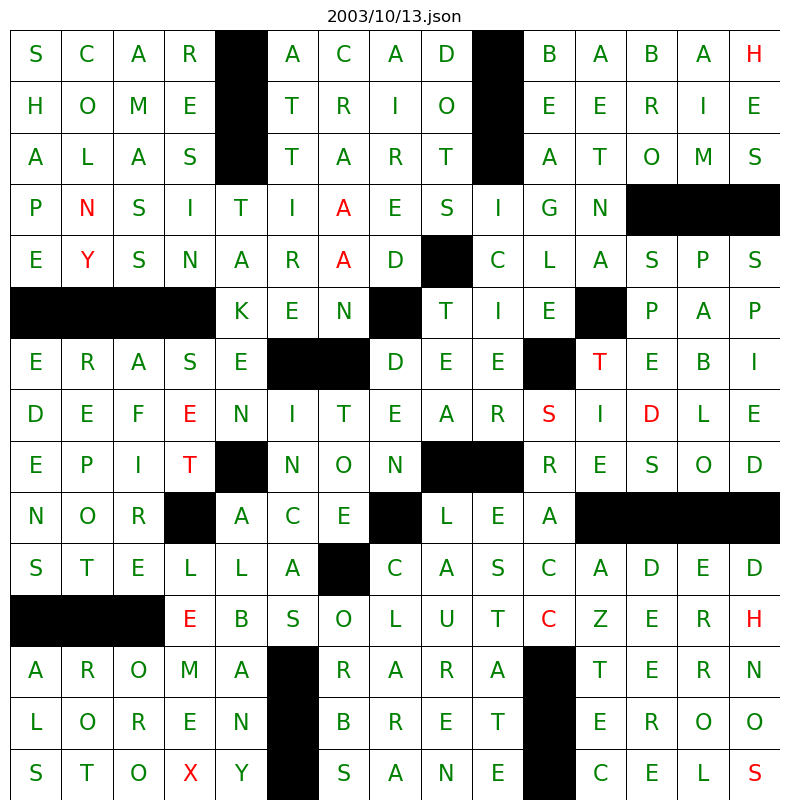

In [110]:
# Given 15x15 array
grid = np.array(truth_list, dtype='str').reshape((n, n))

# Function to plot the crossword puzzle
def plot_crossword(grid):
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # Create a heatmap with white color and no grid lines
    sns.heatmap(grid != '$', cbar=False, square=True, linewidths=.5, linecolor='black', cmap=['black', 'white'], ax=ax)
    
    # Annotate the cells with the numbers
    for i in range(grid.shape[0]):
        for j in range(grid.shape[1]):
            if grid[i, j] != '0' and (i, j) not in crossword.null_squares:
                if grid[i, j] == real_solution[(i, j)]:
                    ax.text(j + 0.5, i + 0.5, grid[i, j], 
                            horizontalalignment='center', 
                            verticalalignment='center',
                            fontsize=16,
                            color='green')
                else:
                    ax.text(j + 0.5, i + 0.5, grid[i, j], 
                            horizontalalignment='center', 
                            verticalalignment='center',
                            fontsize=16,
                            color='red')
            
    
    # Remove axis labels and ticks
    ax.set_xticks([])
    ax.set_yticks([])
    plt.title(file_name)
    plt.savefig(f"solution_grid2.jpg")
    plt.show()

    

# Plot the crossword puzzle
plot_crossword(grid)

In [108]:
fig